In [81]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Этапы
- удаление дубликатов
- работа с пропусками (удаление/заполнение)
- преобразование данных
- работа с выбросами
- очистка

In [82]:
df_orig = pd.read_csv('hh_ru_dataset.csv')

In [83]:
df = df_orig.copy()

In [84]:
df.shape

(500000, 26)

## Дупликаты

In [85]:
df[df.duplicated()].shape
# Out: (0, 26)
## Нет дубликатов

(0, 26)

In [86]:
df.topic_id.unique().shape
# Out: (499949,)
## Значит какие то уникальные идентификаторы повторяются (интересно)

(499949,)

In [87]:
## Уникальные ID, которые повторяются:
df[df.topic_id.map(df.topic_id.value_counts() > 1)].drop_duplicates(subset=['topic_id']).shape
# Out: (51, 26)
## Такие ID, для которых value_count > 1:
df[df.topic_id.map(df.topic_id.value_counts() > 1)].sort_values(by='topic_id').shape
# Out: (102, 26)

(102, 26)

In [88]:
## Просто удалим эти 102 id, так будет проще жить:
df = df[df.topic_id.map(df.topic_id.value_counts() == 1)]

In [89]:
df.shape

(499898, 26)

## Пропуски

In [90]:
df.isnull().sum()

topic_id                        0
topic_creation_date             0
initial_state                 834
final_state                   834
resume_id                       0
resume_creation_date            0
profession                      0
gender                          0
year_of_birth                   0
resume_region                   0
education_level               102
expected_salary             10782
relocation_status               0
business_trip_readiness         0
work_schedule                6911
resume_employment_type          0
work_experience_months          0
resume_skills_list          37444
vacancy_id                      0
vacancy_creation_date           0
vacancy_region                  0
work_schedule.1                 0
vacancy_employment_type         0
compensation_from           29377
compensation_to            138190
vacancy_skills_list             0
dtype: int64

Удаляем *nan* в ***initial_state*** и ***final_state***, так как неизвестны причина и итог взаимодействия

In [91]:
df = df.dropna(subset=['initial_state', 'final_state'])
# удалили пары discard - discard
df = df[df.initial_state != 'discard']

В строке ***education_level*** отсутствуют некторые значения, разберёмся, почему.

In [92]:
df.education_level.unique()

array(['higher', 'unfinished_higher', 'special_secondary', 'secondary',
       'bachelor', 'master', 'candidate', nan, 'doctor'], dtype=object)

При создании резюме [*hh.ru*](hh.ru) предлагает выбрать уровень образования. В списке уровни расположены по возрастанию.

Без указания уровня образования создать резюме не выйдет. Вывод - ошибки при записи данных, тем более таких 102 строки

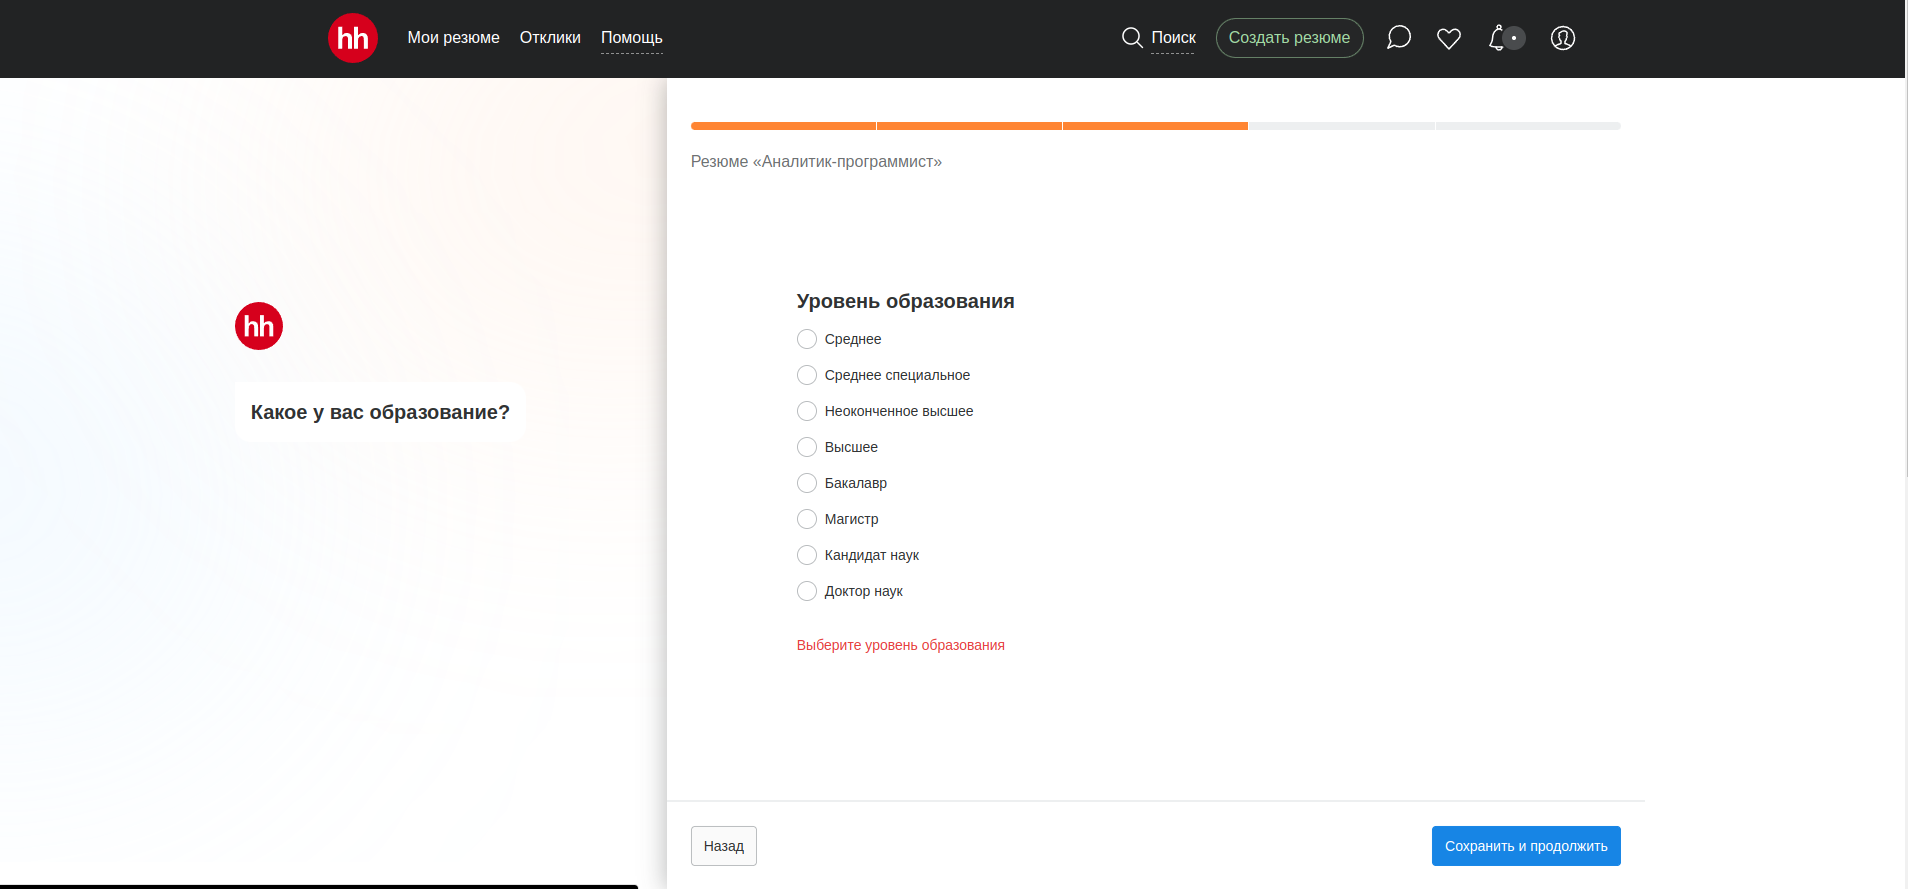

In [93]:
df = df.dropna(subset=['education_level'])

В строке ***expected_salary*** отсутствуют некторые значения, вероятно человек не знает на какую заработную плату ему рассчитывать

Два варианта: выбросить эти данные или заполнить их медианой ожидаемой зарплатой по данной специальности (***profession***)

In [94]:
print(df.groupby(['profession']).agg({'expected_salary': ['median']}).head(10))
# решили выбросить
## 2% выбрасываем
df = df.dropna(subset=['expected_salary'])

                                                   expected_salary
                                                            median
profession                                                        
SMM-менеджер, контент-менеджер                             40000.0
Администратор                                              50000.0
Аналитик                                                   70000.0
Бухгалтер                                                  55000.0
Водитель                                                   65000.0
Воспитатель, няня                                          50000.0
Врач                                                      100000.0
Генеральный директор, исполнительный директор (...        150000.0
Делопроизводитель, архивариус                              50000.0
Дизайнер, художник                                         50000.0


In [95]:
## work_schedule
df.work_schedule.unique()
# Out: ['full_day', 'remote', 'flexible', 'shift', nan]
## 1% выбрасываем
df = df.dropna(subset=['work_schedule'])

Ничего путёвого в ***resume_skills_list*** нет

In [96]:
df.resume_skills_list.nunique()
# Out: 132682
df = df.dropna(subset=['resume_skills_list'])

Есть вариант предсказать ***compensation_from*** для данной вакансии (***vacancy_id***): берем минимальное занчение ***compensation_from*** для профессиии данной вакансии. <br>
**PS: предсказать очень сложно, нужно учитывать регион вакансии, график**

In [97]:
# решили просто удалить, чтобы были полные данные
df = df.dropna(subset=['compensation_from'])

In [98]:
df = df.drop(columns=['compensation_to'])

In [99]:
df = df.reset_index(drop=True)
df.info()
# Всего 79981 строк было удалено (16%), 420019 строк осталось (84%)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420019 entries, 0 to 420018
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   topic_id                 420019 non-null  object 
 1   topic_creation_date      420019 non-null  object 
 2   initial_state            420019 non-null  object 
 3   final_state              420019 non-null  object 
 4   resume_id                420019 non-null  object 
 5   resume_creation_date     420019 non-null  object 
 6   profession               420019 non-null  object 
 7   gender                   420019 non-null  object 
 8   year_of_birth            420019 non-null  int64  
 9   resume_region            420019 non-null  object 
 10  education_level          420019 non-null  object 
 11  expected_salary          420019 non-null  float64
 12  relocation_status        420019 non-null  object 
 13  business_trip_readiness  420019 non-null  object 
 14  work

## Преобразование

In [100]:
df['applicant_age'] = 0
# создадим переменную возраста соискателя
# а именно это возраст, который будет у соискателя к концу 2023 года
for index, row in df.iterrows():
    birth_year = row['year_of_birth']
    df.loc[index, 'applicant_age'] = 2023 - int(birth_year)

In [101]:
df['successful_topic'] =  0
for index, row in df.iterrows():
  if (row['initial_state'] == 'invitation') or (row['final_state'] == 'invitation'):
    df.loc[index, 'successful_topic'] = 1

In [102]:
education_dict = {
    'secondary': 0,
    'special_secondary': 24,
    'unfinished_higher': 12,
    'bachelor': 48,
    'master': 72,
    'higher': 60,
    'candidate': 108,
    'doctor': 144
}
df['study_months'] = df['education_level'].map(education_dict)

In [103]:
df = df.rename(columns={'work_schedule.1': 'work_schedule_required'})

In [104]:
df['gender'] = df['gender'].map({'male': 0, 'female': 1})

## Выбросы

In [105]:
# проверяем временной промежуток для topic_creation_date
dates = df.topic_creation_date.unique().tolist()
years = set()
months = set()
days = set()
for elem in dates:
    years.add(elem[0:4])
    months.add(elem[5:7])
    days.add(elem[8:10])
print(sorted(years))
print(sorted(months))
print(sorted(days))
# всё норм
# resume_creation_date и vacancy_creation_date проверять не нужно
# резюме и вакансии могли быть созданы и раньше

['2023']
['06', '07', '08']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


0.6654512306289881

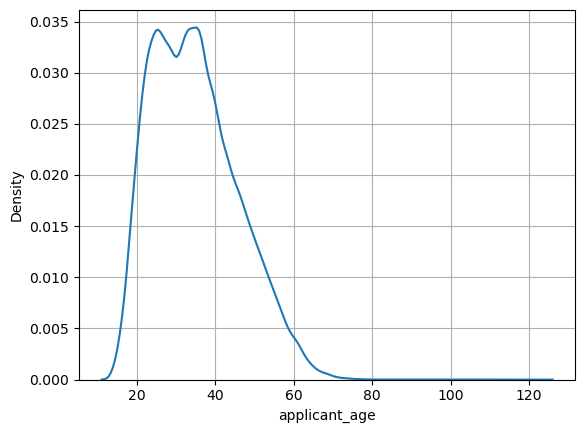

In [106]:
# диаграмма распределения возрастов соискателей по уникальным резюме
unique_resumes = df.drop_duplicates(subset=['resume_id'])
sns.kdeplot(unique_resumes, x='applicant_age')
plt.grid()
unique_resumes[(unique_resumes.applicant_age >= 20)
               & (unique_resumes.applicant_age <= 40)].shape[0] / unique_resumes.shape[0]
# Out: 0.66545
# 67% соискателей имеют возраст от 20 до 40

(160162, 28)
      applicant_age
max       65.000000
mean      34.706463
min       14.000000


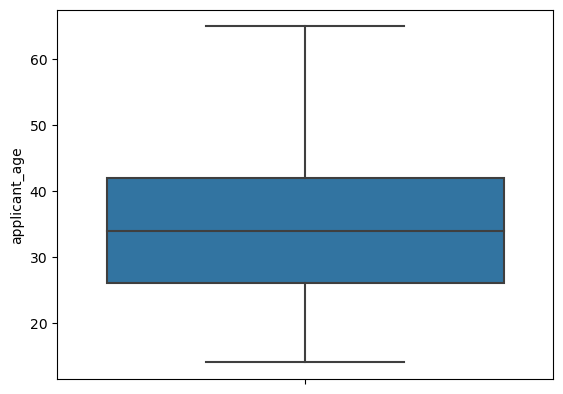

In [107]:
print(unique_resumes.shape)
iqr = unique_resumes.applicant_age.quantile(0.75) - unique_resumes.applicant_age.quantile(0.25)
unique_resumes[
    (unique_resumes.applicant_age < unique_resumes.applicant_age.quantile(0.75) + 1.5 * iqr)
    & (unique_resumes.applicant_age > unique_resumes.applicant_age.quantile(0.25) - 1.5 * iqr)
]
sns.boxplot(unique_resumes[
    (unique_resumes.applicant_age < unique_resumes.applicant_age.quantile(0.75) + 1.5 * iqr)
    & (unique_resumes.applicant_age > unique_resumes.applicant_age.quantile(0.25) - 1.5 * iqr)
], y='applicant_age')
print(unique_resumes[
    (unique_resumes.applicant_age < unique_resumes.applicant_age.quantile(0.75) + 1.5 * iqr)
    & (unique_resumes.applicant_age > unique_resumes.applicant_age.quantile(0.25) - 1.5 * iqr)
].agg({'applicant_age': ['max', 'mean', 'min']}))
#           applicant_age
# max       65.000000
# mean      34.706463
# min       14.000000

In [108]:
# удаляем всех, кто младше 16 или старше 65 (песнионный возраст)
df = df[(df.applicant_age >= 16 ) & (df.applicant_age <= 65)]
unique_resumes = df.drop_duplicates(subset=['resume_id'])

In [109]:
df.resume_region.unique().tolist()
# тут нема Севостополя (город ФЗ)
df.vacancy_region.unique()
# тут нема Херсонской и еще чего то
pass

In [110]:
df[(df.education_level == 'doctor') & ((df.initial_state == 'invitation') | (df.final_state == 'invitation'))]
# забавно, что в наше время, на профессию разнорабочего, бармена,
# уборщика и фитнес-инструктора приглашают людей с докторской степенью

,topic_id,topic_creation_date,initial_state,final_state,resume_id,resume_creation_date,profession,gender,year_of_birth,resume_region,...,vacancy_id,vacancy_creation_date,vacancy_region,work_schedule_required,vacancy_employment_type,compensation_from,vacancy_skills_list,applicant_age,successful_topic,study_months
116553,3412969c396791,2023-06-06 00:00:00.000,response,invitation,1tt62260k,2023-04-16 00:00:00.000,"Официант, бармен, бариста",0,2004,Москва,...,8156k88b,2023-06-05 00:00:00.000,Москва,flexible,full,65000.0,"['пунктуальность', 'коммуникабельность', 'опря...",19,1,144
235487,33c4196441261,2023-07-19 00:00:00.000,response,invitation,18t688550,2022-09-27 00:00:00.000,"Уборщица, уборщик",1,1979,Московская область,...,8b44665k,2023-07-14 00:00:00.000,Москва,remote,part,60000.0,[None],44,1,144
252759,33696964696396,2023-07-28 00:00:00.000,response,invitation,20505ktbb,2023-07-28 00:00:00.000,Разнорабочий,0,1989,Москва,...,8b5kk841,2023-07-17 00:00:00.000,Москва,full_day,full,150000.0,"['ремонтные работы', 'ремонт квартир', 'отделк...",34,1,144
352131,3b91c09696,2023-07-16 00:00:00.000,response,invitation,f08bt060,2019-07-24 00:00:00.000,"Фитнес-тренер, инструктор тренажерного зала",0,1991,Москва,...,8gk8861,2023-06-20 00:00:00.000,Москва,shift,part,90000.0,"['работа в коллективе', 'умение слушать', 'кур...",32,1,144


In [111]:
# Пока что решили удалить эти несчастные 35 строк, на них не получится что-либо сделать
df = df[df.education_level != 'doctor']

Влияет ли ожидаемая зп на итог взаимодействия?

<Axes: >

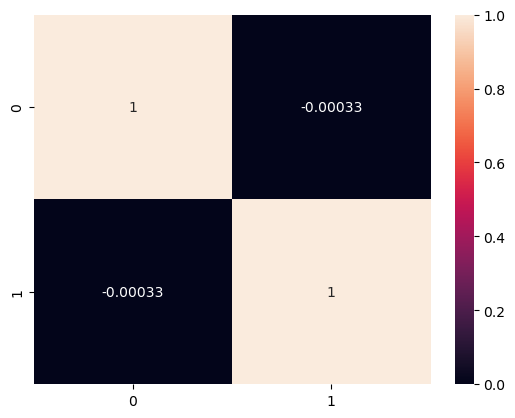

In [112]:
sns.heatmap(np.corrcoef(df['expected_salary'], df['successful_topic']), annot=True)

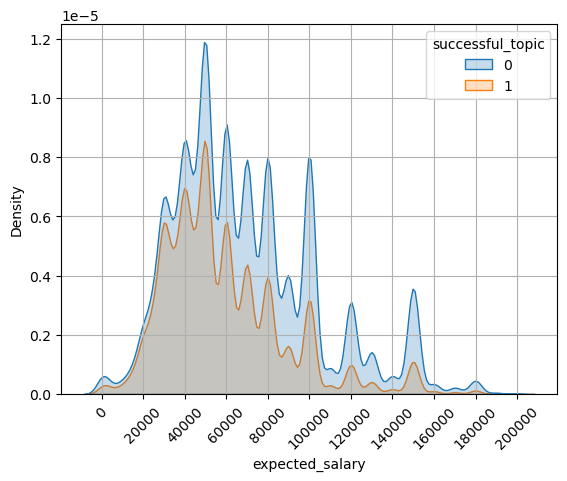

In [113]:
sns.kdeplot(df[df.expected_salary < 200000], x='expected_salary', hue='successful_topic', fill=True)
plt.xticks(np.arange(0, 200001, 20000), rotation=45)
plt.grid()

Кстати, интересный вывод: люди желают получают круглую сумму денег (в десятках тысяч)

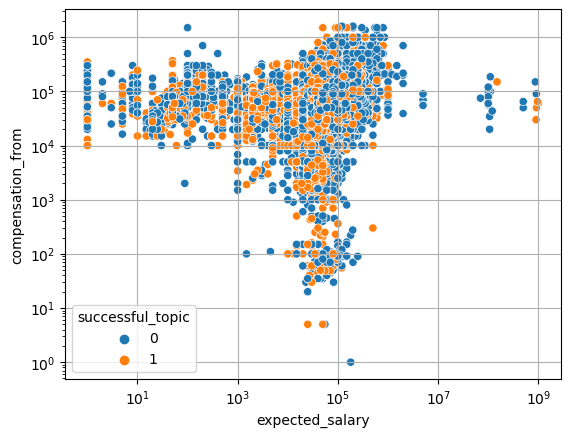

In [114]:
sns.scatterplot(df, x='expected_salary', y='compensation_from', hue='successful_topic')
plt.xscale('log', base=10)
plt.yscale('log', base=10)
plt.grid()

In [115]:
df.relocation_status.unique().tolist()

['not_ready', 'possible', 'desirable']

In [116]:
df.business_trip_readiness.unique().tolist()

['never', 'ready', 'sometimes']

In [117]:
df.resume_employment_type.unique().tolist()
# Out: ['full', 'project', 'part', 'probation', 'volonteer']
# full - полная занятость
# project - проектная работа
# part - частичная занятость
# probation - видимо что то типа стажировки
# volonteer - волонтерская деятельность
df.resume_employment_type.value_counts()
# resume_employment_type
# full         354663
# part          45875
# project       11635
# probation      5102
# volonteer       714
# Name: count, dtype: int64
df.vacancy_employment_type.unique().tolist()
# Out: ['full', 'part', 'probation', 'project', 'volonteer']
df.vacancy_employment_type.value_counts()
# vacancy_employment_type
# full         369456
# part          46026
# probation      3015
# project        1461
# volonteer         2
# Name: count, dtype: int64
# Волонтеры нам не нужны...
df = df[(df.vacancy_employment_type != 'volonteer') | (df.resume_employment_type != 'volonteer')]

Outliers count: 623
Not outliers count: 158351
Rejection %: 0.3934297857291713


,initial_state,final_state
response,50.0,20
invitation,3.0,14
discard,NaN,19


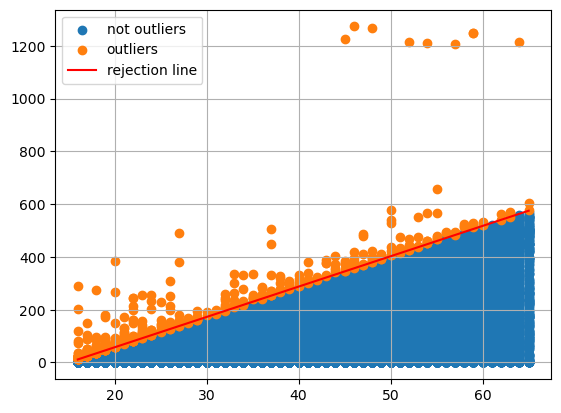

In [118]:
def F(x):
    return 11.5 * (x - 15) # 12 - сколько месяцев работают в году условно, 
x = list(range(16, 66, 1))
y = list(map(F, x))
# Пока не знаем как задать эту прямую
unique_resumes_cp = unique_resumes.copy()
outliers = unique_resumes_cp[unique_resumes_cp.work_experience_months > unique_resumes_cp.applicant_age.apply(F)]
not_outliers = unique_resumes_cp[unique_resumes_cp.work_experience_months <= unique_resumes_cp.applicant_age.apply(F)]
plt.scatter(not_outliers['applicant_age'], not_outliers['work_experience_months'], label='not outliers')
plt.scatter(outliers['applicant_age'], outliers['work_experience_months'], label='outliers')
plt.plot(x, y, label='rejection line', color='r')
plt.legend()
plt.grid()
print(f'Outliers count: {outliers.shape[0]}')
print(f'Not outliers count: {not_outliers.shape[0]}')
print(f'Rejection %: {outliers.shape[0]/not_outliers.shape[0]*100}')
outliers[outliers.applicant_age <= 16].agg({'initial_state': 'value_counts', 'final_state': 'value_counts'})

<Axes: xlabel='applicant_age', ylabel='work_experience_months'>

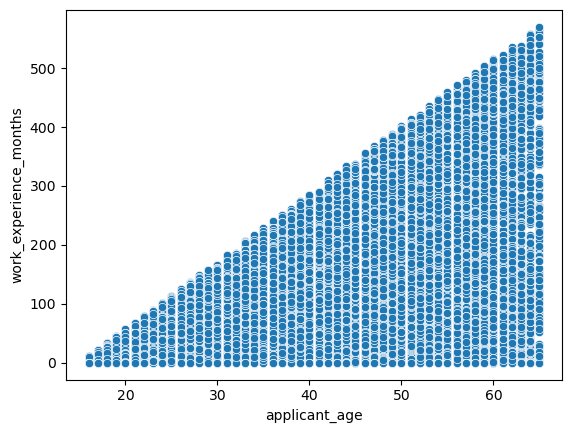

In [119]:
# убираем всех, у кого work_experience_months больше 12 * (appplicant_age - 16)
df = df[df.work_experience_months < df.applicant_age.apply(F)]
unique_resumes = df.drop_duplicates(subset=['resume_id'])
sns.scatterplot(unique_resumes, x='applicant_age', y='work_experience_months')

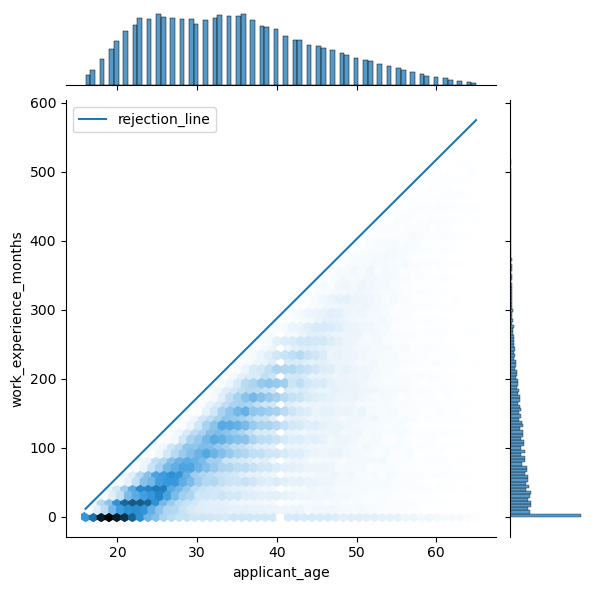

In [120]:
sns.jointplot(unique_resumes, x='applicant_age', y='work_experience_months', kind='hex')
plt.plot(x, y, label='rejection_line')
plt.legend()

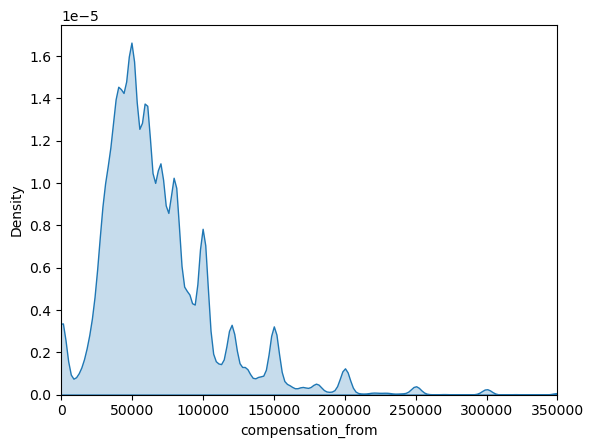

In [121]:
unique_vacancies = df.drop_duplicates(subset=['vacancy_id'])
# не знаю че делать с этим
# если мы говорим про студентов и нормальных людей, то они вряд ли претендуют нна вакансии с минимальной зп 350к рублей
# отсекаем
sns.kdeplot(
    unique_vacancies[unique_vacancies.compensation_from <= 350000],
    x='compensation_from',
    fill=True
)
plt.xlim(0, 350000)
unique_vacancies[unique_vacancies.compensation_from == 0]
df = df[df.compensation_from <= 350000]

# Сохранение

In [122]:
df.to_csv('Processed-hh-ru.csv', index=False)